# Importing relevant classes

In [6]:
from langgraph.graph import START, END, StateGraph
from typing_extensions import TypedDict
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, BaseMessage
from langchain_core.runnables import Runnable
from collections.abc import Sequence 
import config

```python
from langgraph.graph import START, END, StateGraph
```

* **LangGraph** is a library for building workflows with LLMs.
* `START` and `END` → special markers showing where a graph (pipeline) starts and ends.
* `StateGraph` → lets you define a graph of states and transitions (like a flowchart for AI tasks).

---

```python
from typing_extensions import TypedDict
```

* `TypedDict` lets you define a **dictionary with fixed keys and value types**.
* Example:

  ```python
  class MyDict(TypedDict):
      name: str
      age: int
  ```

  → means every `MyDict` must have a `"name"` (string) and `"age"` (integer).

---


```python
from langchain_core.messages import HumanMessage, BaseMessage
```

* `HumanMessage` → represents a message from the **user**.
* `BaseMessage` → the general type for any message (human, AI, system).

---

```python
from langchain_core.runnables import Runnable
```

* `Runnable` → a building block in LangChain.
* It’s like a **function wrapper** that can be chained with others to make a pipeline.

---

```python
from collections.abc import Sequence 
```

* `Sequence` → a generic type meaning “a list-like container” (something you can loop over in order, e.g. list, tuple).

---


In [20]:
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    google_api_key=config.gemini_api_key,
    temperature=0,
    max_tokens=250,
    model_kwargs={"seed": 42}
)
# The seed = 42 ensures your Gemini responses are consistent and repeatable, especially since temperature=0 removes extra randomness.

In [24]:
def AskGeminiAI(question):
    response = llm.invoke(question)
    return response

## Defining a state and a node

In [11]:
class State(TypedDict):
    messages: Sequence[BaseMessage]

In [12]:
state = State(
    messages = [HumanMessage("Could you tell me a grook by Piet Hein?")]
)

In [18]:
state

{'messages': [HumanMessage(content='Could you tell me a grook by Piet Hein?', additional_kwargs={}, response_metadata={})]}

In [15]:
state["messages"][0].pretty_print()

================================ Human Message =================================

Could you tell me a grook by Piet Hein?


In [26]:
AskGeminiAI(state["messages"]).pretty_print()

================================== Ai Message ==================================

Here's a classic Piet Hein grook:

**Problems worthy of attack
prove their worth by hitting back.**


In [33]:
# Node 
def chatbot(state: State) -> State:
    
    print(f"\n-------> ENTERING chatbot:")
    
    response = AskGeminiAI(state["messages"])
    response.pretty_print()
    
    return State(messages = [response])

In [28]:
state

{'messages': [HumanMessage(content='Could you tell me a grook by Piet Hein?', additional_kwargs={}, response_metadata={})]}

In [29]:
chatbot(state)


-------> ENTERING chatbot:
================================== Ai Message ==================================

Here's a classic Piet Hein grook:

**Problems worthy of attack
prove their worth by hitting back.**


{'messages': [AIMessage(content="Here's a classic Piet Hein grook:\n\n**Problems worthy of attack\nprove their worth by hitting back.**", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--793c4e6d-4db6-499d-8ce3-6a0ccd41cbe9-0', usage_metadata={'input_tokens': 11, 'output_tokens': 25, 'total_tokens': 36, 'input_token_details': {'cache_read': 0}})]}

## Building the graph

In [31]:
graph = StateGraph(State)

In [37]:
graph.add_node("chatbotNode", chatbot)

graph.add_edge(START, "chatbotNode")
graph.add_edge("chatbotNode", END)

In [60]:
# Checks if the nodes are connected properly and creates a Runnable object
graph_compiled = graph.compile()

In [40]:
isinstance(graph_compiled, Runnable), isinstance(graph, Runnable)

(True, False)

graph_compiled:

START --> chatbotNode --> END

In [56]:
print(graph.nodes)

{'chatbotNode': StateNodeSpec(runnable=chatbotNode(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None, input_schema=<class '__main__.State'>, retry_policy=None, cache_policy=None, ends=(), defer=False)}


In [54]:
print(graph.edges)

{('chatbotNode', '__end__'), ('__start__', 'chatbotNode')}


In [57]:
state

{'messages': [HumanMessage(content='Could you tell me a grook by Piet Hein?', additional_kwargs={}, response_metadata={})]}

In [58]:
graph_compiled.invoke(state)


-------> ENTERING chatbot:
================================== Ai Message ==================================

Here's a classic Piet Hein grook:

**Problems worthy of attack
prove their worth by hitting back.**

This grook is short, witty, and offers a bit of wisdom about facing challenges. It's a good example of Hein's style.


{'messages': [AIMessage(content="Here's a classic Piet Hein grook:\n\n**Problems worthy of attack\nprove their worth by hitting back.**\n\nThis grook is short, witty, and offers a bit of wisdom about facing challenges. It's a good example of Hein's style.", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--45e83ac1-94d5-443f-8404-e4d61e637af4-0', usage_metadata={'input_tokens': 11, 'output_tokens': 56, 'total_tokens': 67, 'input_token_details': {'cache_read': 0}})]}

## Defining nodes and a routing function

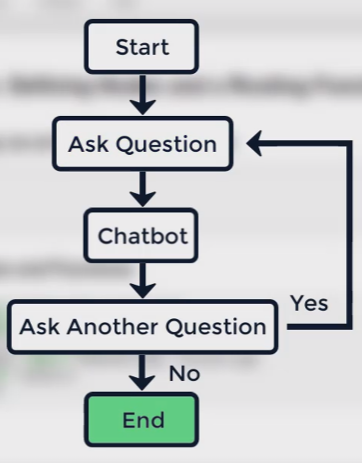

In [65]:
from IPython.display import Image, display

display(Image(filename=r"D:\AI-ML\LangGraph\Files\FlowDiagram.png"))